In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from floyd_steinberg_dithering import floyd_steinberg_dithering, plot, insert_simple, paste_with_mask,get_paste_diaps
from math import *
import io
import json
import random
from functional import seq
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (10,4) 

In [2]:
def rotate_glichless(img, angle, flags=None):
    m = cv2.getRotationMatrix2D((0,0), angle, 1.0)
    p1 = np.array([img.shape[1]/2, img.shape[0]/2])
    p2 = np.array([img.shape[1]/2, -img.shape[0]/2])

    ymax = max( abs(int(np.matmul(p1, m)[1])), abs(int(np.matmul(p2, m)[1])))
    xmax = max( abs(int(np.matmul(p2, m)[0])), abs(int(np.matmul(p1, m)[0])))
    if len(img.shape) == 2:
        img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    img_big = np.zeros((max(ymax*2, img.shape[0]), max(xmax*2, img.shape[1]), img.shape[2]), dtype=img.dtype)
    x1 = int(img_big.shape[1]/2 - img.shape[1]/2)
    x2 = int(img_big.shape[1]/2 + img.shape[1]/2)
    y1 = int(img_big.shape[0]/2 - img.shape[0]/2)
    y2 = int(img_big.shape[0]/2 + img.shape[0]/2)
    insert_simple(img_big, img, x1,y1, x2, y2)
    
    image_center = tuple(np.array(img_big.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    if flags is None:
        flags=cv2.INTER_LINEAR
    res = cv2.warpAffine(img_big, rot_mat, img_big.shape[1::-1], flags=flags)
    return res

def get_mask(img, angle):
    mask = np.zeros_like(img)
    mask[:,:,:] = 255
    mask = rotate_glichless(mask, angle, cv2.INTER_NEAREST)
    return mask

def resize_max_gab(img, max_gab):
    fx = max_gab / img.shape[0] 
    fy = max_gab / img.shape[1] 
    return cv2.resize(img, (0,0), fx=min(fx,fy), fy=min(fx,fy))

class Img(object):
    schemes = {
        'BGR', 'RGB', 'LAB', 'HSV'
    }
    def __init__(self, img, scheme='BGR'):
        if isinstance(img, str):
            self.img = cv2.imread(img)
            self._scheme = 'BGR'
            self.scheme = scheme
            return
        if isinstance(img, Img):
            scheme = img.scheme
            self._scheme = scheme
            self.img = img.img.copy()
            return
        self.img = img
        self._scheme = scheme
        
    @property
    def scheme(self):
        return self._scheme
    
    @scheme.setter
    def scheme(self, new_scheme):
        if new_scheme not in self.schemes:
            raise Exception(f'Нет такой схемы {new_scheme}.  Доступные схемы: {self.schemes}')
        if new_scheme == self._scheme:
            return
        mode = eval(f'cv2.COLOR_{self._scheme}2{new_scheme}')
        self.img = cv2.cvtColor(self.img, mode)
        self._scheme = new_scheme
        
    def plot(self, img=None):
        if img is None:
            img = self.img
        if self._scheme != 'RGB':
            img = cv2.cvtColor(img, eval(f'cv2.COLOR_{self._scheme}2RGB'))
        plt.imshow(img)
        plt.show()
        
    def __repr__(self):
        return f'Img (WxH) =({self.img.shape[1]} x {self.img.shape[0]})  scheme "{self.scheme}"'
    
    def __str__(self):
        return repr(self)
        
    
class ImageCool(Img):
    def __init__(self, img, scheme='BGR', max_gab=100, angle=0):
        super().__init__(img, scheme)
        self.max_gab = max_gab
        self.angle = angle
        self.mask=None
        self.load_img(self.img, scheme)
                      
    def load_img(self, img, scheme='BGR'):
        img = resize_max_gab(img, self.max_gab)
        self.img = rotate_glichless(img, self.angle)
        self.scheme = scheme
        self.mask = get_mask(img, self.angle)
        
    def get_filtered_lab_img(self, dbrightness=0, da=0, db=0):
        dm = np.zeros_like(self.img)
        pbr = dbrightness if dbrightness > 0 else 0
        mbr = -dbrightness if dbrightness <= 0 else 0
        pa = da if da > 0 else 0
        ma = -da if da <= 0 else 0
        pb = db if db > 0 else 0
        mb = -db if db <= 0 else 0
        dm[:,:] = (pbr, pa, pb)
        plus = cv2.add(self.img, dm)
        dm[:,:] = (mbr, ma, mb)
        return cv2.subtract(plus, dm)
        
    def plot(self, background=(0,0,255), dbrightness=0, da=0, db=0):
        res = np.zeros_like(self.img)
        res[:,:] = np.array(background[::-1])
        res_img = Img(res, 'BGR')
        res_img.scheme = self.scheme
        img = self.img
        if dbrightness !=0 or da != 0 or 0 != db:
            img = self.get_filtered_lab_img(dbrightness, da, db)
        paste_with_mask(res_img.img, img, self.mask, (0,0), (0,0))
        res_img.plot()
        
    def insert_me_to(self, img, xc, yc, dbrightness=0, da=0, db=0):
        x, y = self.img.shape[1::-1]
        img2 = self.img
        if dbrightness !=0 or da != 0 or db!= 0:
            img2 = self.get_filtered_lab_img(dbrightness, da, db)
        img_sch = img.scheme
        img.scheme = self.scheme
        paste_with_mask(img.img, img2, self.mask, (xc,yc), (x/2,y/2))
        img.scheme = img_sch
    
    def get_max_likehood_xy(self, img, ret_res=False, ret_w_rect=False, mask=None, dbrightness=0, da=0, db=0):
        if mask is None:
            mask = self.mask
        img2 = self.img
        if dbrightness !=0 or da != 0 or 0 != db:
            img2 = self.get_filtered_lab_img(dbrightness, da, db)        
        res = cv2.matchTemplate(img,img2,cv2.TM_SQDIFF ,mask=mask)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        x,y = min_loc
        w,h = self.img.shape[1::-1]
        result = [x+int(w/2), y+int(h/2)]
        if ret_res:
            result.append(res)
        if ret_w_rect:
            bottom_right = (x + w, y + h)
            imgc = img.copy()
            cv2.rectangle(imgc,(x,y), bottom_right, 255, 2)
            result.append(imgc)
        return tuple(result)
    
    def likehood(self, img, center, mask_additional=None, dbrightness=0, da=0, db=0):
        w, h = self.img.shape[1::-1]
        if mask_additional is None:
            mask = self.mask
        else:
            mask = cv2.multiply(mask_additional, self.mask)
        x1, x2, y1, y2 = get_paste_diaps(img, self.img, center, (int(w/2), int(h/2)))
        img_2 = img[y1:y2, x1:x2]
        x,y,ret = self.get_max_likehood_xy(img_2,True, mask=mask,dbrightness=dbrightness, da=da, db=db)
        summy = ret[0,0]
        return summy/cv2.countNonZero(mask[:,:,0])

In [3]:
n = 256**3
col = np.array([[[0,0,255]]], dtype=np.uint8)
cv2.cvtColor(col, cv2.COLOR_RGB2LAB)

array([[[ 82, 207,  20]]], dtype=uint8)

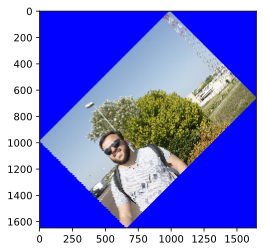

In [4]:
ic = ImageCool('imgs/_MG_7951.jpg',max_gab=1400, angle=45, scheme='LAB')
ic.plot(dbrightness=0, da=0, db=0)


In [14]:
def calc_hist(img, mask=None, hist_bins=8):
    num_channels = img.shape[-1]
    histSize = [hist_bins]*num_channels
    channels=list(range(num_channels))
    hist11 = cv2.calcHist(img, channels=channels, mask=mask, histSize=histSize, ranges=[0,255]*num_channels)
    hist11 /= np.sum(hist11)
    return hist11

def hist_diff(h1, h2):
    h1good=h1>0
    h2good=h2>0
    diff=np.logical_xor(h1good,h2good)
    allz=np.sum(h1[diff]) + np.sum(h2[diff])
    return allz/2

class MegaImageCool(Img):
    def __init__(self, img, scheme = 'BGR', resize_gab=None):
        super().__init__(img, scheme)
        if resize_gab is not None:
            self.img = resize_max_gab(self.img, resize_gab)
        self.ic_dict = {}
        self.hist=None    
        self.hist_bins=None
    
    def __getitem__(self, key):
        gab, angle = key[0], key[1]
        gab = int(gab)
        angle = int(angle)
        h = f'{gab}_{angle}'
        ic = None
        if False: #h in self.ic_dict:
            ic = self.ic_dict[h]
        else:
            ic = ImageCool(self.img, scheme=self.scheme, max_gab=gab, angle=angle)
#             self.ic_dict[h] = ic
        return ic
            
    def set_hist(self, hist_bins=8):
        self.hist = calc_hist(self.img, None, hist_bins)
        self.hist_bins=hist_bins

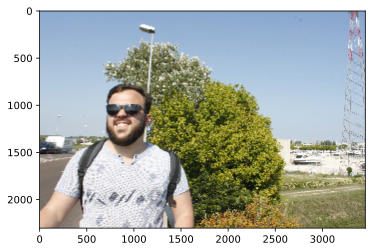

In [15]:
img1 = Img('imgs/_MG_7951.JPG', 'LAB')
img1.plot()

In [16]:
img1

Img (WxH) =(3456 x 2304)  scheme "LAB"

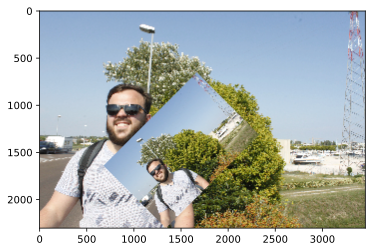

In [17]:
ic.insert_me_to(img1,1500,2000)
img1.plot()

In [18]:
import pickle
from tqdm import tqdm
import glob

# all_imgs = []

# for fn in tqdm(glob.glob('imgs/*')):
#     try:
#         mic = MegaImageCool(fn, scheme = 'LAB', resize_gab=300)
#         all_imgs.append(mic)
#     except Exception as e:
#         print(f'{fn},   {e}')

with open('all_imgs.bin', 'rb') as f:
    all_imgs=pickle.load(f)

In [19]:
tmp=[]
for mic in tqdm(all_imgs):
    try:
        mic.set_hist(12)
    except Exception as e:
        print(f'{e}')
    else:
        tmp.append(mic)
all_imgs = tmp

  0%|                                                                                 | 1/1553 [00:00<05:29,  4.72it/s]E:\imyimy\env_imyimy\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
100%|████████████████████████████████████████████████████████████████████████████| 1553/1553 [00:00<00:00, 3313.42it/s]


In [20]:

with open('all_imgs.bin', 'wb') as f:
    pickle.dump(all_imgs, f)

In [21]:
class Image_region(Img):
    def __init__(self, img, p1, p2, scheme='BGR'):
        super().__init__(img, scheme)
        self.p1 = p1
        self.p2 = p2
        self.mask = self.get_mask()
        self.hist = None
        self.hist_bins = None
        self.similars = []
        
    def set_hist(self, hist_bins=12):
        self.hist = calc_hist(self.img[self.p1[1]:self.p2[1], self.p1[0]:self.p2[0]], hist_bins=hist_bins)
        self.hist_bins = hist_bins
    
    def get_mask(self):
        mask = np.zeros(self.img.shape[:2], dtype=np.uint8)
        mask[self.p1[1]:self.p2[1], self.p1[0]:self.p2[0]] = 255
        return mask
    
    def plot_zone(self):
        self.plot(self.img[self.p1[1]:self.p2[1], self.p1[0]:self.p2[0]])
        
    def plot_with_rect(self, thickness=5):
        img = self.img.copy()
        imgy = Img(img, self.scheme)
        imgy.scheme = 'RGB'
        cv2.rectangle(imgy.img, self.p1, self.p2, color=(0,0,255),thickness=thickness)
        imgy.plot()
        
    def get_similar(self, all_mics, threshold=0.3, max_count=None):
        res = []
        for mic in all_mics:
            try:
                mic.scheme = self.scheme
                if self.hist_bins != mic.hist_bins:
                    mic.set_hist(self.hist_bins)
                diff = hist_diff(mic.hist, self.hist)
                if diff < threshold:
                    res.append((diff, mic))
            except Exception as e:
                print(e)
        res.sort(key = lambda tp: tp[0])
        if max_count is not None and max_count < len(res):
            res = res[:max_count]
        return res
    

class Collage(Img):
    def __init__(self, img, nx=13, nx_len=10, ny = 13, ny_len=10, scheme='BGR'):
        super().__init__(img, scheme)
        self.nx = nx
        self.ny = ny
        self.nx_len = nx_len
        self.ny_len = ny_len
        self.regions = []
        self.threshold = 0.1
    
    def get_rects(self):
        w_img, h_img = self.img.shape[1::-1]
        w = int(w_img / self.nx_len)
        h = int(h_img / self.ny_len)
        
        mnw = (w_img-w)/(self.nx-1)
        mnh = (h_img-h)/(self.ny-1)
        xs = [int(i*mnw) for i in range(self.nx)]
        ys = [int(i*mnh) for i in range(self.ny)]
        return [((x,y),(x+w, y+h)) for x in xs for y in ys]
    
    def plot_rects(self, thickness=4):
        imgy = Img(self)
        imgy.scheme = 'RGB'
        w_img, h_img = imgy.img.shape[1::-1]
        def get_col(x, y):
#             return (255,0,0)
            return (random.randint(0,255), random.randint(0,255), random.randint(0,255))
        for p1, p2 in self.get_rects():
#             print(p1, p2, get_col(*p1))
            cv2.rectangle(imgy.img, p1, p2, color=get_col(*p1), thickness=thickness)
#         print(seq(self.get_rects()).map(lambda tp: tp[1][0]).max(), w_img)
        imgy.plot()
    
    def set_similars(self, all_mics, threshold=None, hist_bins=12, max_count=None):
        self.regions = [Image_region(self.img, p1, p2, scheme=self.scheme) for p1, p2 in self.get_rects()]
        if threshold is None:
            threshold = self.threshold
        else:
            self.threshold = threshold
        for ir in tqdm(self.regions):
            ir.set_hist(hist_bins)
            ir.similars = ir.get_similar(all_mics, threshold, max_count=max_count)
        print(f'Max count {seq(self.regions).map(lambda ir: len(ir.similars)).max()}')   
        print(f'Min count {seq(self.regions).map(lambda ir: len(ir.similars)).min()}')   

In [22]:
seq(all_imgs).map(lambda mic: max(mic.img.shape)).average()

300.0

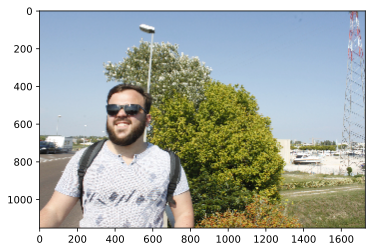

Img (WxH) =(1728 x 1152)  scheme "LAB"


In [23]:
img1 = cv2.imread('imgs/_MG_7951.JPG')
img1 = cv2.resize(img1, (0,0), fx=0.5, fy=0.5)
img1 = Img(img1, 'BGR')
img1.scheme = 'LAB'
img1.plot()
print(img1)

In [24]:
1728/300, 1152/300

(5.76, 3.84)

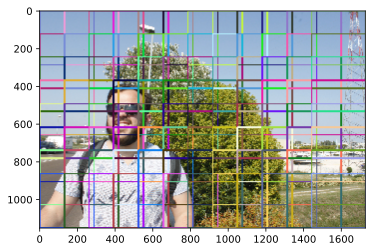

In [25]:
col = Collage(img1,12,6,8,4)
col.plot_rects(8)

In [26]:

col.scheme = 'LAB'
col.set_similars(all_imgs, 0.2, 12,150)

  0%|                                                                                           | 0/96 [00:00<?, ?it/s]E:\imyimy\env_imyimy\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 15.53it/s]


Max count 150
Min count 3


In [27]:
col.regions[1:3]

[Img (WxH) =(1728 x 1152)  scheme "LAB",
 Img (WxH) =(1728 x 1152)  scheme "LAB"]

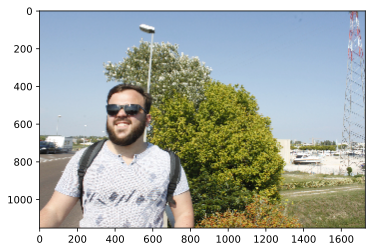

In [28]:
col.regions[0].plot()

In [36]:
from copy import deepcopy
from opti.Chromosome import SRange, DRange, IRange, ChromoController

class ChromoContrCollage(object):
    def __init__(self, collage):
        self.collage = collage
        self.chr_contrs = self.get_chr_contrs()
    
    def get_im_reg_chr_contr(self, im_reg):
        img_inds = [f'{i}' for i in range(len(im_reg.similars))]
        img_inds.append('no_img')
        img_ind_gene = SRange(img_inds, 'img_ind')
#         angles = list(range(-170,181,10))
        angle_gene = DRange(-179, 180, 'angle')
#         max_gabs = list(range(100,301,25))
        max_gab_gene = DRange(50,200, 'max_gab')
        xc_gene = DRange(im_reg.p1[0], im_reg.p2[0], 'xc')
        yc_gene = DRange(im_reg.p1[1], im_reg.p2[1], 'yc')
        dbrightness_gene = DRange(-120,120, 'dbrightness')
        da_gene = DRange(-30,30, 'da')
        db_gene = DRange(-30,30, 'db')
        chr_contr = ChromoController([img_ind_gene, angle_gene, max_gab_gene, xc_gene, yc_gene,da_gene,db_gene,dbrightness_gene])
        return chr_contr

    def get_chr_contrs(self):
        return [self.get_im_reg_chr_contr(im_reg) for im_reg in self.collage.regions]
        
    def get_chromo(self):
        order = list(range(len(self.chr_contrs)))
        random.shuffle(order)
        return {
            'sub_chromos':[cc.get_chromo() for cc in self.chr_contrs],
            'order': order}
    
    def get_img(self, chromo):
        res = np.zeros_like(self.collage.img)
        resImg = Img(res)
        resImg.scheme = self.collage.scheme
        for i in chromo['order']:
            sub_chromo = chromo['sub_chromos'][i]
            img_reg = self.collage.regions[i]
            img_ind_s = sub_chromo['img_ind']
            if img_ind_s == 'no_img':
                continue
            img_ind = int(img_ind_s)
            mega_img_cool = img_reg.similars[img_ind][1]
            angle = sub_chromo['angle']
            max_gab = int(sub_chromo['max_gab'])
            img_cool = mega_img_cool[max_gab, angle]
            dbrightness = sub_chromo['dbrightness']
            da = sub_chromo['da']
            db = sub_chromo['db']
            xc = sub_chromo['xc']
            yc = sub_chromo['yc']
#             def insert_me_to(self, img, xc, yc, dbrightness=0, da=0, db=0):
            img_cool.insert_me_to(resImg, xc, yc, dbrightness, da, db)

        return resImg
    
    def fitness(self, chromo):
        img = self.get_img(chromo)
        diff = cv2.subtract(self.collage.img, img.img)
        diff = diff.astype(np.float64)
        return -np.average(np.sqrt(np.sum(diff*diff, axis=2)))
    
    def cross(self, chromo1, chromo2, prob):
        ofspr_order = self.cross_4_orders(chromo1['order'], chromo2['order'])
        ofspr_sub_chromos = []
        for schr1, schr2, cc in zip(chromo1['sub_chromos'], chromo2['sub_chromos'], self.chr_contrs):
            ofspr_sub_chr = deepcopy(random.choice([schr1, schr2]))
            if schr1['img_ind'] == schr1['img_ind'] :
                for k in ofspr_sub_chr:
                    if random.random() >= prob:
                        continue
                    ofspr_sub_chr[k] = cc[k].cross(schr1[k], schr1[k])
            ofspr_sub_chromos.append(ofspr_sub_chr)
        return {
            'sub_chromos': ofspr_sub_chromos, 
            'order': ofspr_order }
    
    def mutate(self, chromo, prob):
        ofspr = deepcopy(chromo)
        while random.random() < prob:
            i1 = random.randint(0, len(ofspr['order'])-1)
            i2 = random.randint(0, len(ofspr['order'])-1)
            #swap
            ofspr['order'][i1], ofspr['order'][i2] = ofspr['order'][i2], ofspr['order'][i1]
        for cc, ofspr_sub_chr in zip(self.chr_contrs, ofspr['sub_chromos']):
            for k in ofspr_sub_chr:
                if random.random() < prob:
                    ofspr_sub_chr[k] = cc[k].mutate(ofspr_sub_chr[k])
        return ofspr
        
    def cross_4_orders(self, order1, order2):
        road_map =[set([]) for i in range(len(order1))]
        for i, c in enumerate(order1):
            road_map[c].add(order1[i-1])
            road_map[c].add(order1[(i+1)%len(order1)])
        for i, c in enumerate(order2):
            road_map[c].add(order2[i-1])
            road_map[c].add(order2[(i+1)%len(order2)])
        offspring = []
        offspring_set = set([])
        rnd_ord = random.choice([order1, order2])
        emerg_set=set(rnd_ord)
        
        first_city = random.choice(rnd_ord)
        offspring.append(first_city)
        offspring_set.add(first_city)
        while len(offspring) != len(order1):
            road_map[offspring[-1]].difference_update(offspring_set)
            emerg_set.difference_update(offspring_set)
            city = offspring[-1]
            next_variants = list(road_map[city])        
            if len(next_variants) > 0:
                next_city = random.choice(next_variants)
            else:
                next_city = list(emerg_set)[0]
            offspring.append(next_city)
            offspring_set.add(next_city)            
        return offspring

In [37]:
ccc = ChromoContrCollage(collage=col)

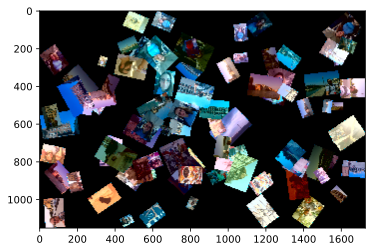

In [38]:
chromoz = ccc.get_chromo()
cc_img = ccc.get_img(chromoz)
cc_img.plot()

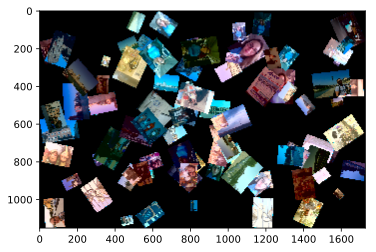

In [39]:
ccc.get_img(ccc.mutate(chromoz, 0.5)).plot()

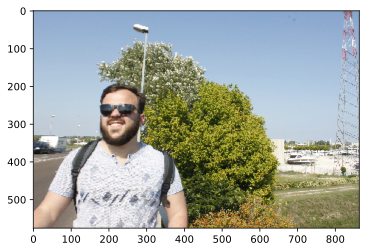

Img (WxH) =(864 x 576)  scheme "LAB"


In [40]:
img4_col = cv2.imread('imgs/_MG_7951.JPG')
img4_col = cv2.resize(img4_col, (0,0), fx=0.25, fy=0.25)
img4_col = Img(img4_col, 'BGR')
img4_col.scheme = 'LAB'
img4_col.plot()
print(img4_col)

In [41]:
collage = Collage(img4_col, 13,6,9,4)
collage.scheme = 'LAB'
collage.set_similars(all_imgs, 0.13, 8, 150)

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 21.38it/s]


Max count 150
Min count 23


In [42]:
chr_contr_col = ChromoContrCollage(collage=collage)
n_pop = 130

pop = [{ 'fitness': None, 'chromo': chr_contr_col.get_chromo()}  for i in range(n_pop)]
pops = [pop]
bests=[]

In [43]:
def fitness_foo(chromo):
    return chr_contr_col.fitness(chromo)

def get_parents(pop, n_pair):
    parents = []
    for jjjj in range(n_pair):
        i1, i2 = np.random.choice(range(len(pop)),size=2,replace=False)
        winer1 = pop[i1]['chromo'] if pop[i1]['fitness'] > pop[i2]['fitness'] else pop[i2]['chromo']
        
        i1, i2 = np.random.choice(range(len(pop)),size=2,replace=False)
        winer2 = pop[i1]['chromo'] if pop[i1]['fitness'] > pop[i2]['fitness'] else pop[i2]['chromo']
        
        parents.append((winer1, winer2))
    return parents

In [65]:
p_cross = 0.8
p_mut = 0.2
n_ellite = 33

gener_step=30
for i in tqdm_notebook(range(gener_step)):
    pop = pops[-1]
    for wchromo in pop:
        if wchromo['fitness'] is None:
            wchromo['fitness'] = fitness_foo(wchromo['chromo'])

    mutants = [{'fitness':None, 'chromo': chr_contr_col.mutate(wchr['chromo'],p_mut)} 
               for wchr in pop if random.random() < p_mut]

    parents = get_parents(pop, n_pop - n_ellite - len(mutants))
    children = [{'fitness':None, 'chromo': chr_contr_col.cross(p1,p2, p_cross)} 
               for p1,p2 in parents]

    pop.sort(key=lambda wchr: wchr['fitness'], reverse=True)
    elite = list(pop[:n_ellite])
    bests.append(elite[0])
    pop2 = elite+children+mutants
    random.shuffle(pop2)
    pops.append(pop2)   
    

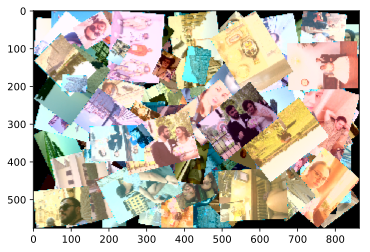

In [66]:
chr_contr_col.get_img(bests[-1]['chromo']).plot()

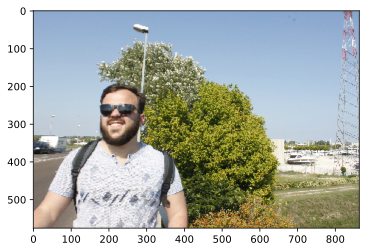

In [54]:
img4_col.plot()

In [ ]:
from matplotlib import ticker
def show_image_histogram_2d(image, bins=8, tick_spacing=5):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    channels_mapping = {0: 'B', 1: 'G', 2: 'R'}
    num_channels = img1.shape[-1]
    histSize = [16]*num_channels
    channels=list(range(num_channels))
    hist11 = cv2.calcHist(img1, channels=channels, mask=None, histSize=histSize, ranges=[0,255]*num_channels)
    for i, channels in enumerate([[0, 1], [0, 2], [1, 2]]):
        hist = cv2.calcHist(
            [image], channels, None, [bins] * 2, [0, 256] * 2)/np.sum(hist11)

        channel_x = channels_mapping[channels[0]]
        channel_y = channels_mapping[channels[1]]

        ax = axes[i]`
        ax.set_xlim([0, bins - 1])
        ax.set_ylim([0, bins - 1])

        ax.set_xlabel(f'Channel {channel_x}')
        ax.set_ylabel(f'Channel {channel_y}')
        ax.set_title(f'2D Color Histogram for {channel_x} and {channel_y}')

        ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

        im = ax.imshow(hist)

    fig.colorbar(im, ax=axes.ravel().tolist(), orientation='orizontal')
    fig.suptitle(f'2D Color Histograms with {bins} bins', fontsize=16)
    plt.show()

In [ ]:
show_image_histogram_2d(img1)

In [ ]:
fx = 0.5
img2 = img1[int(800*fx):int(1500*fx), int(1000*fx):int(1700*fx), :].copy()
ic = ImageCool(int(700*fx), -60)
ic.load_img(img2)
ic.plot()

In [ ]:
mask_add = np.zeros_like(ic.mask)
mask_add[:,:,:]=255
cv2.rectangle(mask_add, (20,200), (300,350), thickness=10, color=(0,0,0))
plt.imshow(cv2.multiply(mask_add, ic.mask))

In [ ]:
ic.mask[0,0]

In [ ]:
x,y,r = ic.get_max_likehood_xy(img1,True)

In [ ]:
ic.likehood(img1,(x,y))

In [ ]:
0.048384642425652456

In [ ]:
plot(ic.insert_me_to(img1, x,y))

In [ ]:

mic = MegaImageCool(img1, 200)

In [ ]:
mic[200, -30].plot()

In [ ]:
img2 = cv2.add(200, img1)
plot(img2)

In [ ]:
img1[100,100], img2[100,100]